<a href="https://colab.research.google.com/github/Divyanshu-ISM/Machine-Learning-Deep-Learning/blob/main/LSTM_GoogleStocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Variate Time Series Forecasts to predict Google's Stock Prices. 

> Divyanshu Vyas | Oil and Gas Data Science / Machine Learning

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
df = pd.read_csv('/content/Google_Stock_Price_Train.csv',index_col=0,parse_dates=True)

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [7]:
df.shape

(1258, 5)

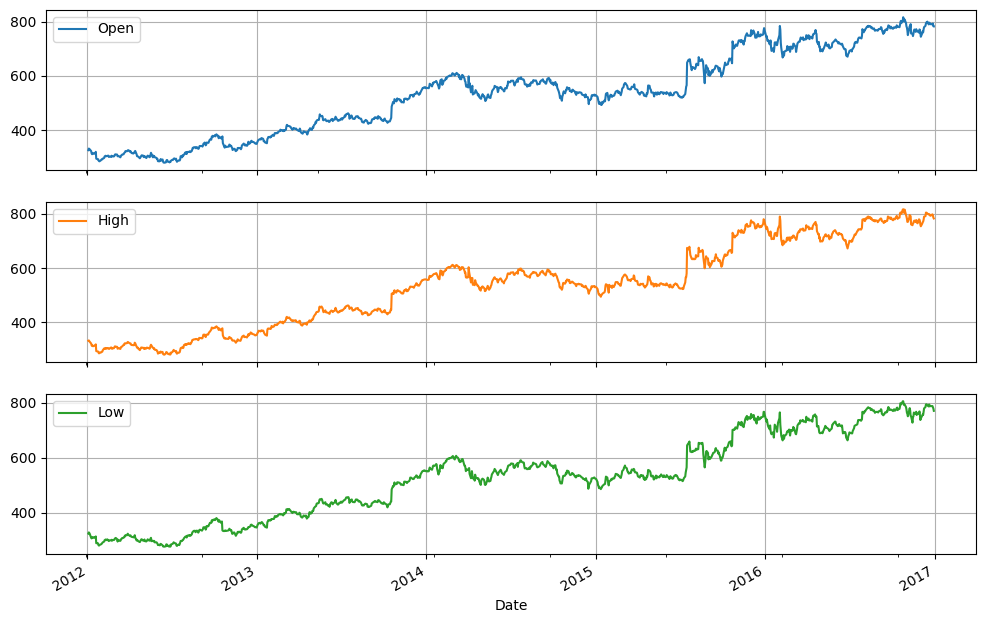

In [8]:
plt.style.use('default')
df.plot(figsize=(12,8),subplots=True,grid=True);

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [10]:
def turn_numeric(x):

  y = str(x).replace(',','')

  z = pd.to_numeric(y)

  return z


In [11]:
V = df['Volume'].apply(turn_numeric)

In [12]:
df['Volume'] = V

In [13]:
C = df['Close'].apply(turn_numeric)

df['Close'] = C

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


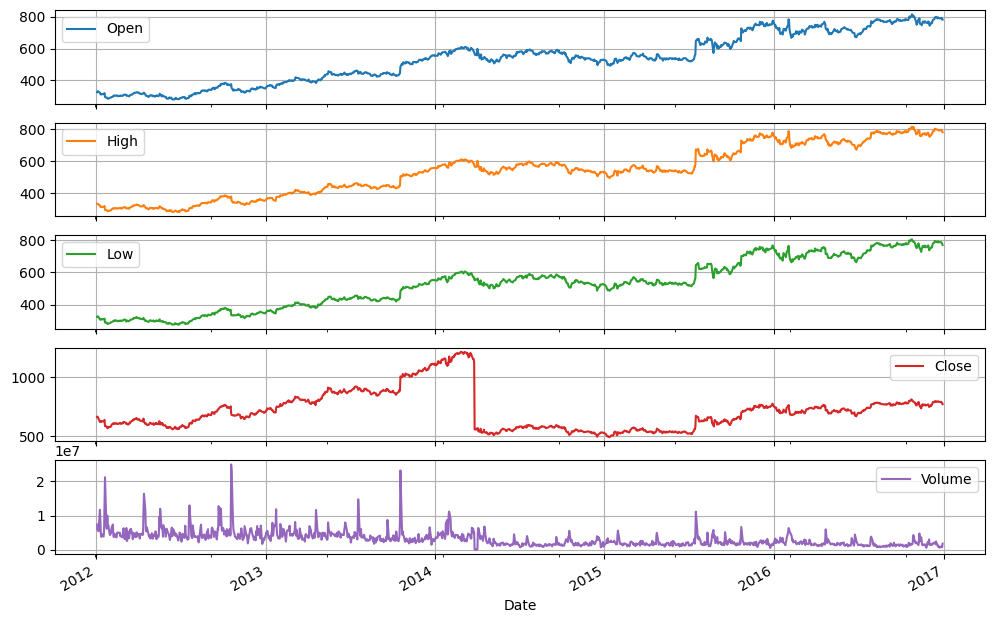

In [15]:
plt.style.use('default')
df.plot(figsize=(12,8),subplots=True,grid=True);

In [16]:
input_cols = ['High','Low','Close','Volume']
output_cols = ['Open']

In [17]:
#Since this is the training Dataset itself.
#but still to make terminology consistent.
df_train = df.copy()

So, We want to use the 60 Days Input and Predict the output of 60th Day.

First, Scaling the Dataset.

In [18]:
scaler = MinMaxScaler()

df_train_scaled = scaler.fit_transform(df_train)

In [19]:
df_train_scaled = pd.DataFrame(data=df_train_scaled,
                               columns=df_train.columns)

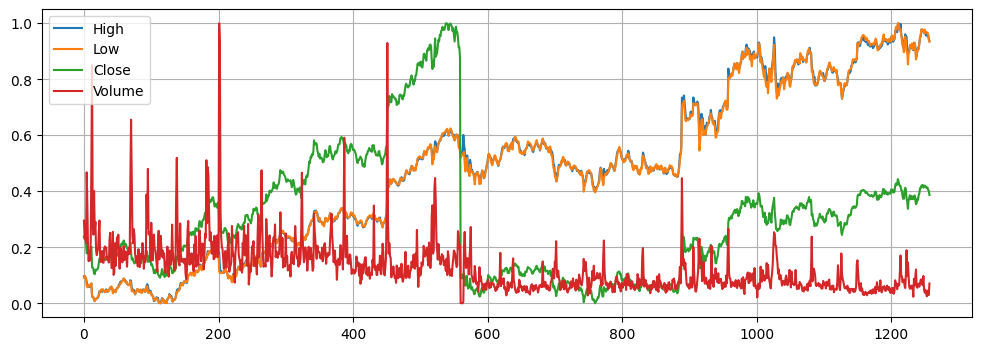

In [20]:
df_train_scaled.iloc[:,1:].plot(figsize=(12,4),grid=True)

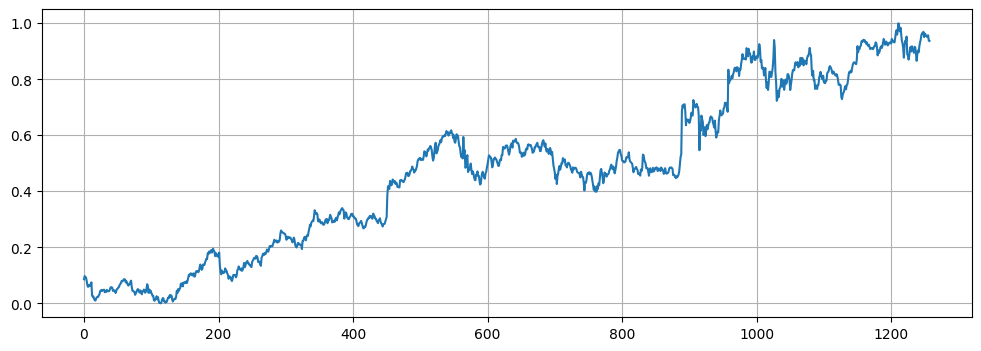

In [21]:
df_train_scaled.iloc[:,0].plot(figsize=(12,4),grid=True)

Creating Training Batches.

> Plan is to use 60 days of Input and predict 60th Day of output(y). 

> 60 days is called 'look-up' time/period here.

In [22]:
def batcher(look_up_time_steps,df_train):

  l = look_up_time_steps

  X = df_train.iloc[:,1:]
  y = df_train.iloc[:,0]

  X_train = []
  y_train = []

  for i in range(l,len(df_train)):

    batchX = X.iloc[i-l:i,:]
    X_train.append(batchX)

    batchY = y.iloc[i]
    y_train.append(batchY)

  X_train = np.array(X_train)
  y_train = np.array(y_train)

  return X_train,y_train



In [32]:
X_train , y_train = batcher(10,df_train_scaled)

In [33]:
X_train.shape

(1248, 10, 4)

In [34]:
y_train.shape

(1248,)

You can imagine the input as a cube/cuboid. (3-Dimensional). 

1. z = 1248 = No. of Slices/Layers of the cube.
2. y = 10 = Look_up_period. 
3. x = 4 = No. of input features. 

So, the input array shape is - X_train.shape ==> (z,y,x).

In [35]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [36]:
num_features = 4
window_length = 10

y = window_length
x = num_features

In [54]:
regressor = Sequential()

regressor.add(LSTM(100,activation='relu',input_shape=(y,x),return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(80,activation='relu',return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(20,activation='relu',return_sequences=False))
regressor.add(Dropout(0.10))

regressor.add(Dense(1))

In [55]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 100)           42000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 80)            57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                8080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

Compile the Model.

In [56]:
regressor.compile(optimizer='adam',loss='mse')

TRAINING/FITTING.

In [57]:
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
39/39 [==============================] - 3s 19ms/step - loss: 0.1588
Epoch 2/100
39/39 [==============================] - 1s 20ms/step - loss: 0.0087
Epoch 3/100
39/39 [==============================] - 1s 20ms/step - loss: 0.0076
Epoch 4/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0065
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0057
Epoch 7/100
39/39 [==============================] - 1s 23ms/step - loss: 0.0057
Epoch 8/100
39/39 [==============================] - 1s 24ms/step - loss: 0.0063
Epoch 9/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0050
Epoch 10/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0045
Epoch 11/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 12/100
39/39 [==============================] - 1s 18ms/step - loss: 0.0047
Epoch 13/100
39/39 [=====

In [58]:
yp = regressor.predict(X_train)

In [59]:
yp.shape

(1248, 1)

In [60]:
y_train.shape

(1248,)

In [64]:
xax = df_train.index[:-y]
xax.shape

(1248,)

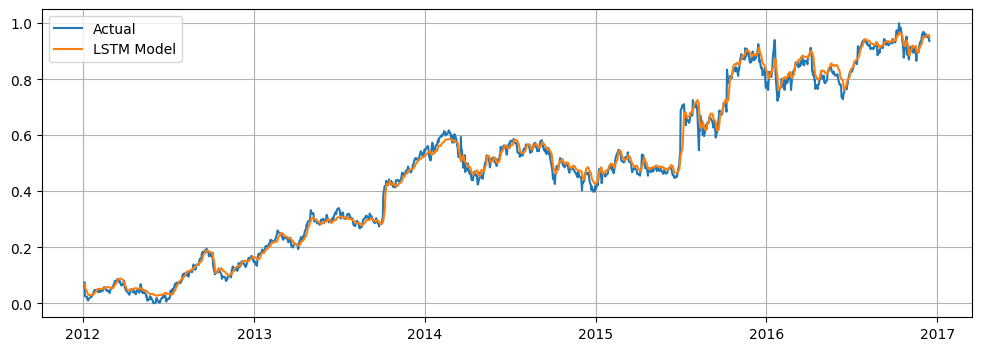

In [69]:
plt.figure(figsize=(12,4))
plt.plot(xax,y_train)
plt.plot(xax,yp)

plt.legend(['Actual','LSTM Model'])
plt.grid()

## Model Evaluation and Testing Phase.

In [70]:
test = pd.read_csv('/content/Google_Stock_Price_Test.csv',index_col=0,parse_dates=True)

In [72]:
V = test['Volume'].apply(turn_numeric)

In [73]:
test['Volume'] = V 

In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 960.0 bytes


In [76]:
df_test_scaled = scaler.transform(test)

In [77]:
df_test_scaled = pd.DataFrame(data=df_test_scaled,columns=test.columns)

In [78]:
df_test_scaled.head()

,Open,High,Low,Close,Volume
0,0.929552,0.949484,0.944423,0.406461,0.066055
1,0.947318,0.952677,0.958365,0.407508,0.042655
2,0.943076,0.958541,0.961888,0.417320,0.053156
3,0.960153,0.983603,0.975489,0.434037,0.065370
4,0.980877,0.987469,0.995624,0.434726,0.050641


In [79]:
# l is the look-up time and its value is 10 here. 

last_l_days = df_train_scaled.tail(window_length)

In [80]:
df_final_test = last_l_days.append(df_test_scaled,ignore_index=True)

In [82]:
# df_final_test

In [83]:
X_test , y_test = batcher(window_length,df_final_test)

In [85]:
X_test.shape , y_test.shape

((20, 10, 4), (20,))

In [86]:
yp_test_scaled = regressor.predict(X_test)

In [87]:
yp_test_scaled.shape

(20, 1)

In [89]:
xax_test = test.index

(0.6, 1.1)

<Figure size 1200x200 with 0 Axes>

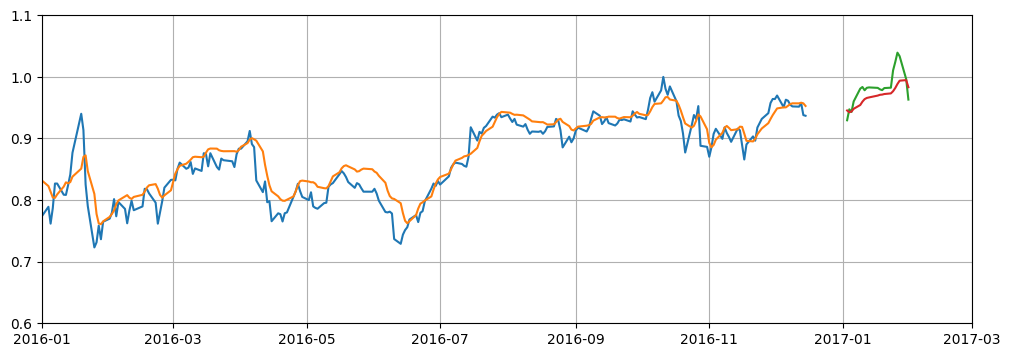

In [109]:
plt.figure(figsize=(12,2))

plt.figure(figsize=(12,4))
plt.plot(xax,y_train)
plt.plot(xax,yp)


plt.grid()
plt.plot(xax_test,y_test)
plt.plot(xax_test,yp_test_scaled)

plt.xlim(pd.to_datetime('01-01-2016'),pd.to_datetime('01-March-2017'))
plt.ylim(0.6,1.1)

In [112]:
y_coef = scaler.scale_[0]

In [114]:
yp_test_actual = yp_test_scaled/y_coef

In [115]:
yp_train_actual = yp/y_coef

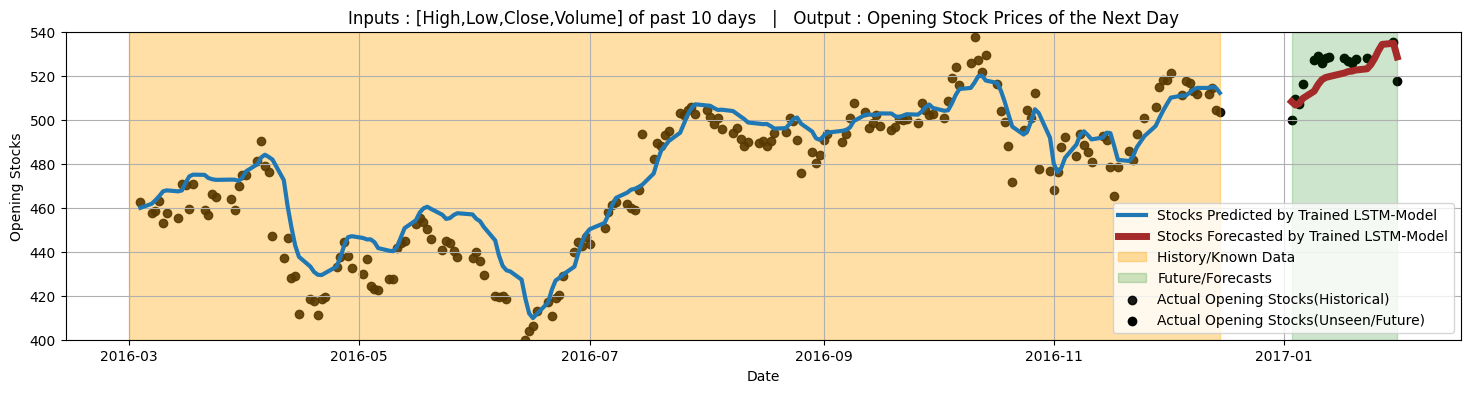

In [161]:
plt.figure(figsize=(18,4))
plt.scatter(xax[-200:],y_train[-200:]/y_coef , label='Actual Opening Stocks(Historical)',color='black',alpha=0.9)
plt.plot(xax[-200:],yp_train_actual[-200:] , label= 'Stocks Predicted by Trained LSTM-Model',lw=3)

# plt.axvspan(d1,d2,color='orange',alpha=0.35,label='History/Known Data')
plt.scatter(xax_test,y_test/y_coef,label='Actual Opening Stocks(Unseen/Future)',color='black')
plt.plot(xax_test,yp_test_actual,lw=5,color='brown',label= 'Stocks Forecasted by Trained LSTM-Model')


d1 = pd.to_datetime('1-Mar-2016') ; d2 = pd.to_datetime('2016-12-15')
d3 = pd.to_datetime('2017-01-03') ; d4 = pd.to_datetime('2017-01-31')


plt.axvspan(d1,d2,color='orange',alpha=0.35,label='History/Known Data')
plt.axvspan(d3,d4,color='green',alpha=0.2,label='Future/Forecasts')

plt.title('Inputs : [High,Low,Close,Volume] of past 10 days   |   Output : Opening Stock Prices of the Next Day')
plt.xlabel('Date')

plt.ylabel('Opening Stocks')

plt.ylim(400,540)
plt.grid()
plt.legend()

In [136]:
# y_train

In [162]:
# xax


In [163]:
# xax_test